# Previsione a 14 giorni

Previsione a 14 giorni con modello SARIMA.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

I nuovi casi giornalieri previsti a 14 giorni sono stimati utilizzando un modello di autoregressione $\mathrm{SARIMA}(p,d,q)\times(P,D,Q,s)$, i cui parametri ottimali sono stati determinati per [grid-search](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b) sul prodotto cartesiano di range empirici, scegliendo la combinazione di parametri che [minimizzi](https://machinelearningmastery.com/probabilistic-model-selection-measures/) il Bayesian Information Criterion ([BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)).

In modello migliore è attualmente

$$
\mathrm{SARIMA}(0, 1, 6)\times(0, 1, 10, 7)
$$

con BIC = $5269.954$. I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

I nuovi casi ad un giorno sono stimati anche con modello ad albero decisionale [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) in Supervised Machine Learning (**GBR-SML**) con `scikit-learn`, basato sull'osservazione della derivata prima dei nuovi positivi dei 28 giorni precedenti e i cui parametri ottimali sono stati determinati per cross-validation, scegliendo la combinazione che massimizzi $R^2$ in-sample e out-of-sample.

In [1]:
import numpy as np
import pandas as pd
import itertools
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [3]:
df.index = df.index.normalize()

In [4]:
df['variazione_nuovi_positivi'] = df.nuovi_positivi.diff()

In [5]:
ts = df[['variazione_nuovi_positivi']].dropna()

In [6]:
features_n = 7 * 4
DF = pd.DataFrame(
    columns=[f'day_{i}' for i in range(features_n + 1)],
    index=ts.index[features_n:]
)
for i in range(features_n + 1):
    _df = ts.iloc[i:(ts.index.size - features_n + i)]
    #print(_df.size)
    DF.iloc[:,i] = _df.values

In [7]:
X_train = DF.iloc[:,:7*4]
Y_train = DF.iloc[:,-1].values

In [8]:
mdl_params = {
    'alpha': 0.95,
    'criterion': 'mse',
    'learning_rate': 0.15,
    'loss': 'ls',
    'max_depth': 4,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0,
    'min_impurity_split': None,
    'min_samples_leaf': 1,
    'min_samples_split': 14,
    'min_weight_fraction_leaf': 0,
    'n_estimators': 5000,
    'subsample': 1,
    'verbose': 0,
    'random_state': 1976,
}

In [9]:
# Initialize the estimator
mdl = GradientBoostingRegressor(**mdl_params)

In [10]:
mdl.get_params()

{'alpha': 0.95,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'init': None,
 'learning_rate': 0.15,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 5000,
 'n_iter_no_change': None,
 'random_state': 1976,
 'subsample': 1,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [11]:
# Fit the data
mdl.fit(X_train, Y_train)
# Make predictions
Y_pred = mdl.predict(X_train)
score = mdl.score(X_train, Y_train)

In [12]:
Y_future = mdl.predict(pd.DataFrame(DF.iloc[-1,1:]).T)[0] + df.nuovi_positivi.values[-1]
X_future = df.index[-1] + pd.Timedelta(days=1)
Y_obs = df.nuovi_positivi[29:]
Y_pre = pd.DataFrame({
    'nuovi_positivi': Y_pred.cumsum()+df.nuovi_positivi[28]
}, index=Y_obs.index)

In [13]:
#df.index = df.index.to_period('D')

In [14]:
### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M', print_res=False):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in tqdm(pdq, leave=False):
        for combs in tqdm(pdqs, leave=False):
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                if print_res:
                    print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

In [15]:
_ = """
# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Remember to change frequency to match your time series data
ans_df = sarimax_gridsearch(df.nuovi_positivi, pdq, pdqs, freq='D')"""

In [16]:
df.index.name = None

In [17]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df.nuovi_positivi, 
                                    order=(0,1,6), 
                                    seasonal_order=(0,1,10,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
sarimax_fit = sarimax.fit()

In [18]:
forecast = sarimax_fit.forecast()

predict_past = sarimax_fit.predict()

predict_future = sarimax_fit.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(days=7*2+1))

# Previsione

In [19]:
Markdown(f"""
Previsione per il {X_future.date().strftime('%d %b %Y')}

- GBR-SML = {Y_future:,.0f}
- SARIMAX = {forecast.values[0]:,.0f}
""")


Previsione per il 23 Mar 2021

- GBR-SML = 17,444
- SARIMAX = 18,294


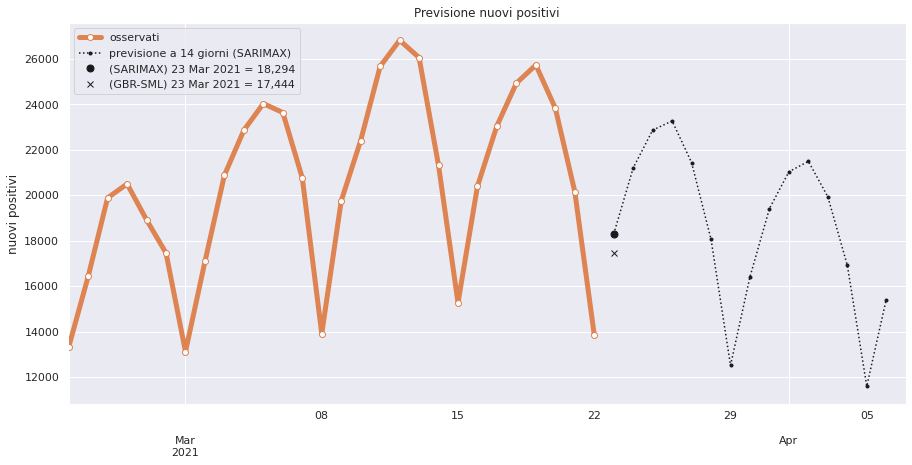

In [20]:
ax = df.iloc[-28:].nuovi_positivi.plot(
    lw=5, marker='o', mfc='w',
    label='osservati', figsize=(15, 7), zorder=100, color='C1'
)
predict_future[1:].plot(ax=ax, color='k', ls=':', marker='.', label='previsione a 14 giorni (SARIMAX)')
ax.plot(
    forecast, marker='o', ms=7, ls='none', color='k', 
    label=f"(SARIMAX) {X_future.date().strftime('%d %b %Y')} = {forecast.values[0]:,.0f}")
ax.plot(
    X_future, Y_future, marker='x', color='k', ls='none',
    label=f"(GBR-SML) {X_future.date().strftime('%d %b %Y')} = {Y_future:,.0f}",
)

ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1]+pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi',
    ylabel='nuovi positivi'
)
ax.legend(loc='upper left')
plt.show()

# Diagnostica

## SARIMAX

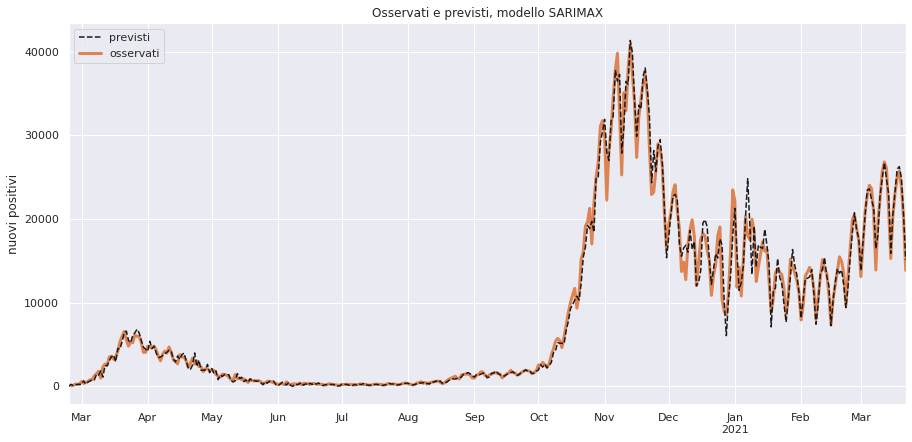

In [21]:
ax = predict_past.plot(
    figsize=(15, 7), title='Osservati e previsti, modello SARIMAX',
    ls='--', zorder=100,
    color='k', label='previsti',
    ylabel='nuovi positivi'
)
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.legend(loc='upper left')
plt.show()

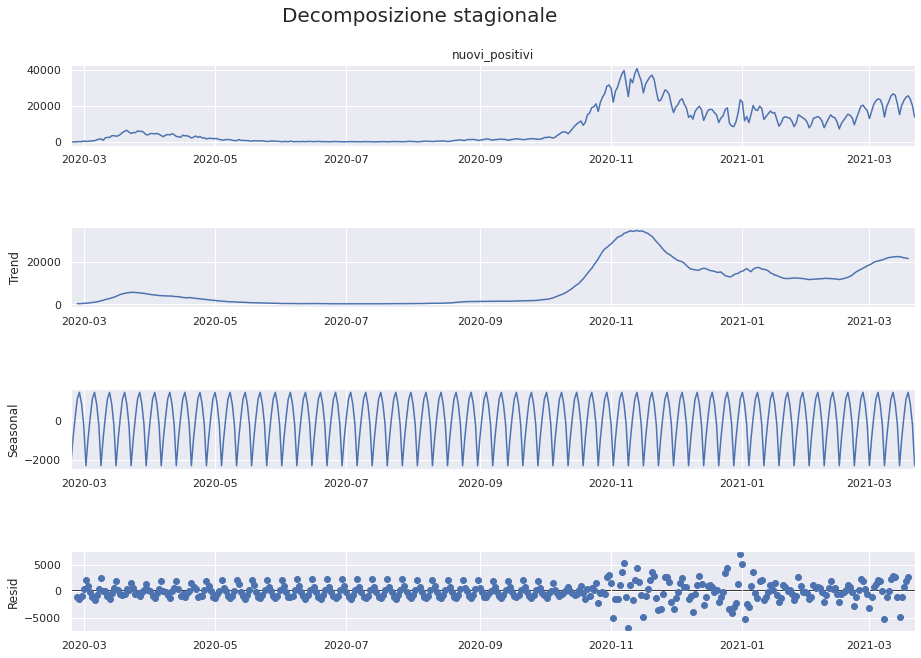

In [22]:
res = sm.tsa.seasonal_decompose(df.nuovi_positivi.dropna())
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Decomposizione stagionale', fontsize=20)
plt.show()

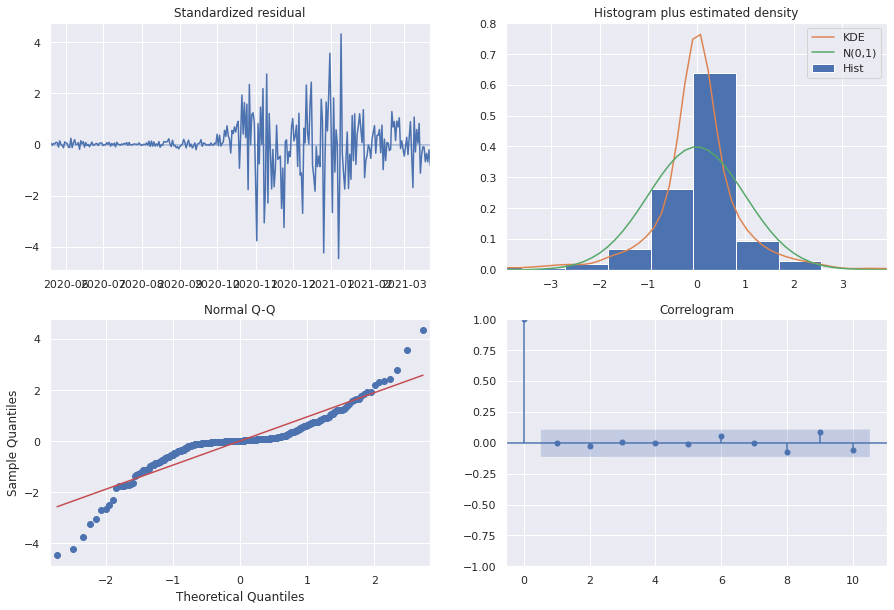

In [23]:
# Plot diagnostics
sarimax_fit.plot_diagnostics(figsize=(15,10));

In [24]:
# Print output summary
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                    SARIMAX Results                                                    
=======================================================================================================================
Dep. Variable:                                                  nuovi_positivi   No. Observations:                  393
Model:             SARIMAX(0, 1, 6)x(0, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 7)   Log Likelihood               -2679.134
Date:                                                         Mon, 22 Mar 2021   AIC                           5392.267
Time:                                                                 17:47:19   BIC                           5455.679
Sample:                                                             02-24-2020   HQIC                          5417.622
                                                                  - 03-22-2021                                         
Covariance Type:                                                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2086      0.052     -4.048      0.000      -0.310      -0.108
ma.L2         -0.2229      0.045     -5.004      0.000      -0.310      -0.136
ma.L3          0.0464      0.046      1.000      0.317      -0.045       0.137
ma.L4         -0.1174      0.054     -2.183      0.029      -0.223      -0.012
ma.L5          0.1187      0.047      2.541      0.011       0.027       0.210
ma.L6          0.2073      0.049      4.202      0.000       0.111       0.304
ma.S.L7       -0.4215      0.041    -10.338      0.000      -0.501      -0.342
ma.S.L14      -0.2100      0.056     -3.741      0.000      -0.320      -0.100
ma.S.L21      -0.0952      0.062     -1.541      0.123      -0.216       0.026
ma.S.L28       0.0334      0.066      0.506      0.613      -0.096       0.163
ma.S.L35      -0.0711      0.078     -0.911      0.362      -0.224       0.082
ma.S.L42      -0.0604      0.083     -0.726      0.468      -0.223       0.102
ma.S.L49      -0.0432      0.063     -0.691      0.489      -0.166       0.079
ma.S.L56       0.0634      0.087      0.729      0.466      -0.107       0.234
ma.S.L63       0.0100      0.096      0.104      0.917      -0.178       0.198
ma.S.L70       0.0392      0.089      0.439      0.660      -0.136       0.214
sigma2      2.317e+06   1.29e+05     17.917      0.000    2.06e+06    2.57e+06
===================================================================================
Ljung-Box (Q):                       45.62   Jarque-Bera (JB):               470.26
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):             234.57   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

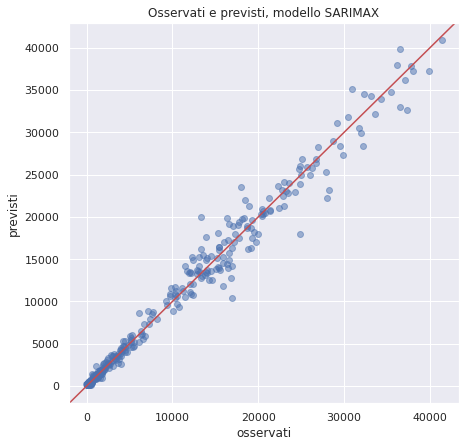

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    predict_past.values, df.nuovi_positivi.values,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello SARIMAX'
)
plt.show()

## Gradient Boosting

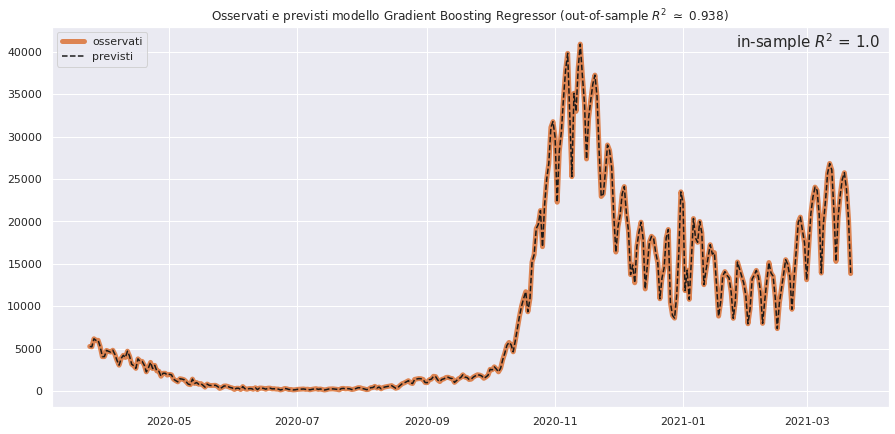

In [26]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(Y_obs, lw=5, label='osservati', color='C1')
ax.plot(Y_pre, label='previsti', color='k', ls='--')
ax.legend(loc='upper left')
ax.text(
    .99, .99, 
    f"in-sample $R^2$ = {score}",
    transform=ax.transAxes, fontsize=15,
    ha='right', va='top',
)
ax.set(
    title='Osservati e previsti modello Gradient Boosting Regressor '
    '(out-of-sample $R^2$ $\simeq$ 0.938)'
)
plt.show()

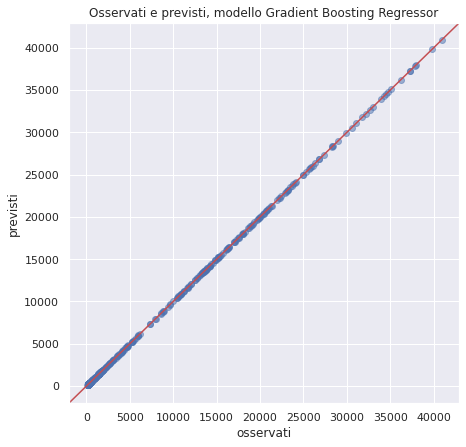

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    Y_obs, Y_pre,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello Gradient Boosting Regressor'
)
plt.show()

## Sequential cross-validation

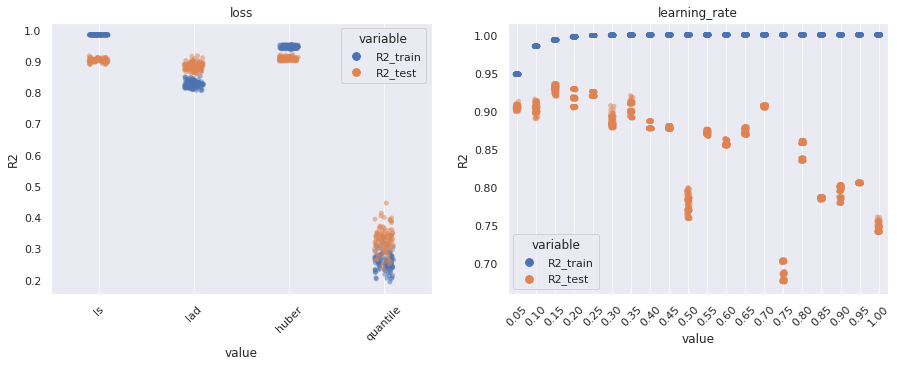

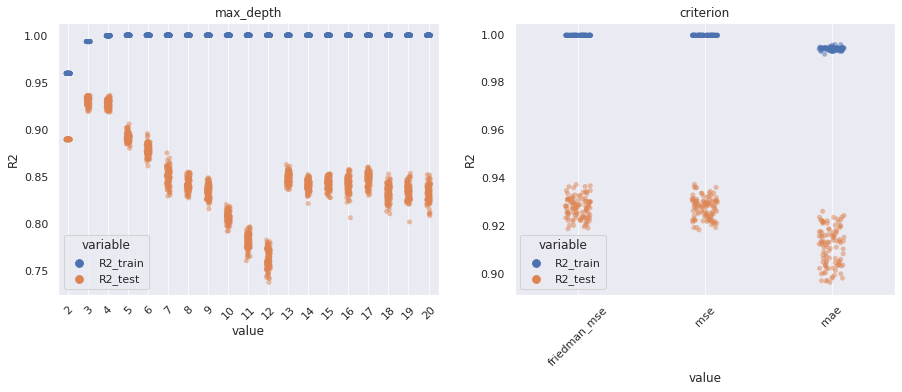

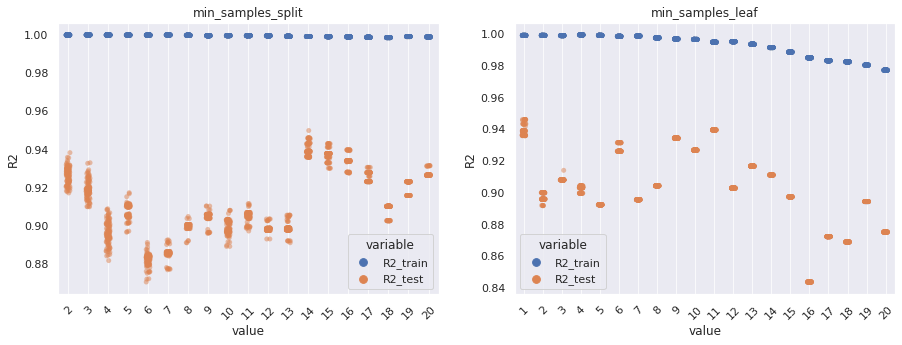

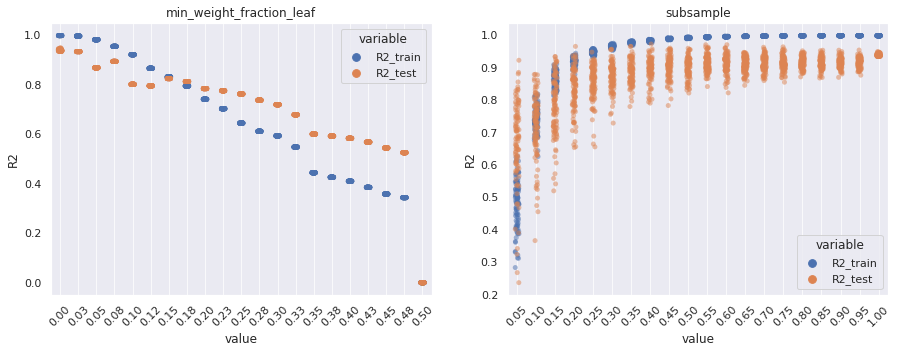

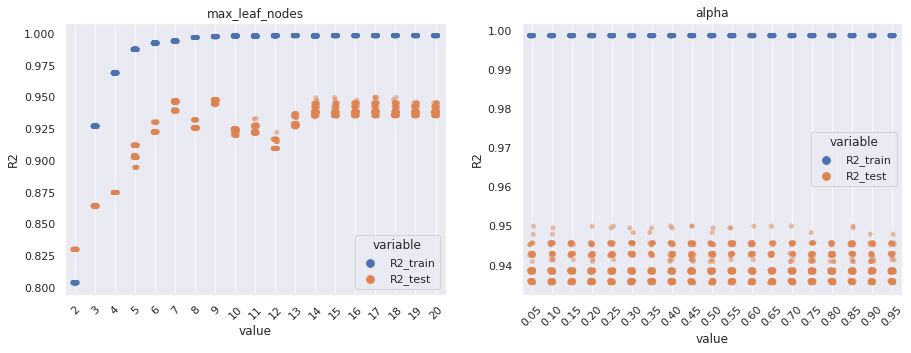

In [28]:
cv = pd.read_csv('cross_validation.csv')

cv = cv.melt(id_vars=['param', 'value',], value_name='R2')

cv = cv[cv.param!='min_impurity_decrease']

for j, param in enumerate(cv.param.unique()):
    i = j % 2
    if not i:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    _cv = cv[cv.param==param].copy(deep=True)
    try:
        _cv['value'] = _cv.value.astype(float)
    except Exception as err:
        pass
    g = sns.stripplot(
        data=_cv,
        x='value', y='R2',
        hue='variable',
        alpha=.5,
        ax=ax.flat[i],
    )
    xticklabels = ax.flat[i].get_xticklabels()
    try:
        if float(xticklabels[0].get_text()) >= 1:
            xticklabels = [f"{float(i.get_text()):.0f}" for i in xticklabels]
        else:
            xticklabels = [f"{float(i.get_text()):.2f}" for i in xticklabels]
    except Exception as err:
        pass
    ax.flat[i].set(
        title=param,
    )
    ax.flat[i].set_xticklabels(
        xticklabels, rotation=45
    )
    ax.flat[i].grid(alpha=.75)
    if i == 1:
        plt.show()